v1.0

The objective of this notebook is to:
- perform failure anaylsis with KMeans clustering

# Pre-checks

In [283]:
## Check for Google Drive Connectivity
try:
    from google.colab import drive
    drive.mount('/content/drive')
    google_env = True
except:
    print("Not a Goolge Drive Environment.")
    google_env = False

Not a Goolge Drive Environment.


In [284]:
import time
t_start = time.time()

# Setup Environment

## Install Modules

In [285]:
#!pip install icecream
#!pip install watermark
#!pip install fastparquet

## Import Modules

In [286]:
# Base libraries
import os
from datetime import date

# Scientific libraries
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,5)

sns.set(rc={'figure.figsize':(7,5)})
sns.set(font_scale=1.0)

# Helper libraries
from watermark import watermark
from icecream import ic
import gc # garbage collection to optimize memory usage: use "gc.collect()"
import warnings
warnings.filterwarnings('ignore')

# Pandas options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Load magic commands
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


## Global Parameters

In [287]:
seed = 42
cpu_count = os.cpu_count()
cpu_count = cpu_count-2  # to keep machine responsive when fitting the models
notebook_no = "0x.0x"

## Global Helper Functions

In [288]:
import http.client
import urllib


def send_push(message):
    """Send push notifications to pushover service."""
    try:
        conn = http.client.HTTPSConnection("api.pushover.net:443")
        conn.request("POST", "/1/messages.json",
                     urllib.parse.urlencode({
                         "token": "ahs1q4mwpnxe3645zeaqzas69whq7a",  # ML Notifications Channel
                         "user": "u5vr1qkc9ghudg2ehuug153okeiz1d",
                         "message": message,
                     }), {"Content-type": "application/x-www-form-urlencoded"})

        conn.getresponse()

    except:
        print("There was a communication issue (pushover).")


In [289]:
def fast_run_sampling(df, sample_fraction):
    """Return a fraction of the dataset."""
    print("Labels before sampling:\n", df['label'].value_counts())
    df = df.groupby('label').sample(frac=sample_fraction, random_state=seed) 
    #df = df.sample(n=sample_size, random_state=seed).reset_index(drop=True)
    print("Labels after sampling:\n", df['label'].value_counts())
    return df
    

In [290]:
def calculate_duration(t_start, t_end):
    """Return run time in minutes."""
    total_runtime = t_end-t_start
    total_runtime_min = round((total_runtime/60), 2)
    print(str(total_runtime_min)+" minutes")

    return total_runtime_min


# 3.0 Load Data

In [291]:
# Load Data
if google_env:
    # Location for "shared with" people
    # create a shortcut of the shared folder in your Google Drive root folder
    ROOT_PATH = "/content/drive/MyDrive/SIADS696/Environment/"
else:
    ROOT_PATH = "../"
    print("Not a Google Drive Environment. Loading local files.")

PATH_DATA = "data/"
PATH_DATA_RAW = "data/raw/"
PATH_DATA_INT = "data/interim/"
PATH_DATA_PRO = "data/processed/"
PATH_DATA_MOD = "models/"
PATH_DATA_REP = "reports/"
PATH_DATA_FIG = "reports/figures/"
PATH_DATA_HTML = "reports/html/"

Not a Google Drive Environment. Loading local files.


In [292]:
df_rfecv_selected_feature = pd.read_csv(ROOT_PATH+PATH_DATA_INT+"RFECV10-RF-selected_features-table_04.02.csv")
rfecv_selected_feature = sorted(df_rfecv_selected_feature['Selected Features'].to_list())
ic(len(rfecv_selected_feature));

ic| len(rfecv_selected_feature): 125


In [293]:
features_include = 4

important_feature = df_rfecv_selected_feature.sort_values('Importance', ascending=False).head(features_include)
important_feature_list = important_feature['Selected Features'].to_list()
ic(important_feature_list);

ic| important_feature_list: ['stats_char_count',
                             'w2v_gen_avg_word2vec_mean',
                             'aoa_aoa_kup_lem_mean',
                             'w2v_ft_sen2vec_mean']


In [294]:
df_all = pd.read_parquet(
    ROOT_PATH+PATH_DATA_INT+"RF_base_model_RFECV_features_results_for_failure_analysis.parquet.gzip")

ic(df_all .shape);


ic| df_all .shape: (416768, 129)


In [295]:
df_all['label'].value_counts()

1    208384
0    208384
Name: label, dtype: int64

# Failure Analysis

In [296]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer

## Prepare data / dataframes

In [297]:
# Filter only on failed/incorrect predicitions
df_failed = df_all [df_all ['label'] != df_all ['y_pred']]
ic(df_failed.shape);

ic| df_failed.shape: (104719, 129)


In [298]:
ic(df_failed['label'].value_counts())

ic| df_failed['label'].value_counts(): 0    55282
                                       1    49437
                                       Name: label, dtype: int64


0    55282
1    49437
Name: label, dtype: int64

In [299]:
# Add some required features to the list, required later in the review of failed samples
important_feature_list.append('label')
important_feature_list.append('y_pred')
important_feature_list.append('original_text')
important_feature_list.append('cleaned_text')

In [300]:
# Subset failed samples only with the important features
df_failed_selected = df_failed[important_feature_list].copy()
ic(df_failed_selected.shape);

ic| df_failed_selected.shape: (104719, 8)


In [301]:
# Group the DataFrame by the 'feature' column and get the count of 
# samples for each feature
#grouped = df_failed_selected.groupby(['label','stats_char_count']).size().plot(kind='hist', bins=50, figsize=(10,10))


In [302]:
# Select on 0 predicted incorrectly
df_failed_selected_0 = df_failed_selected[df_failed_selected['label'] == 0]
#df_failed_selected_0 = df_failed_selected_0.replace(-1, np.nan)
#df_failed_selected_0 = df_failed_selected_0.dropna()

# Select on 1 predicted incorrectly
df_failed_selected_1 = df_failed_selected[df_failed_selected['label'] == 1]
#df_failed_selected_1 = df_failed_selected_1.replace(-1, np.nan)
#df_failed_selected_1 = df_failed_selected_1.dropna()

ic(df_failed_selected_0.shape);
ic(df_failed_selected_1.shape);

ic| df_failed_selected_0.shape: (55282, 8)
ic| df_failed_selected_1.shape: (49437, 8)


## Clustering failed samples (true label 0)

Exlploring why the model predicted 1 instead of the true label 0.

In [303]:
# Prepare X and only use the relevant columns/features
X_columns_train = df_failed_selected_0.columns.to_list()
X_columns_train = list(set(X_columns_train) -{"label", "original_text", "cleaned_text", "stats_language_code", "y_pred"})

X = df_failed_selected_0[X_columns_train].copy()
y = df_failed_selected_0["label"]

ic(X.shape);
ic(y.shape);


ic| X.shape: (55282, 4)
ic| y.shape: (55282,)


In [304]:
# Normalize data using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X)


### Create Clusters

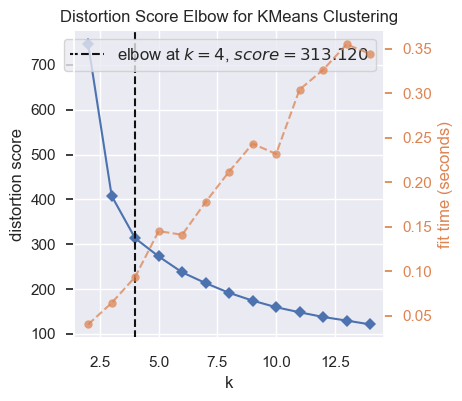

In [305]:
# Calculate best n_cluster value with Elbow method

# Visualization
plt.rcParams["figure.figsize"] = (4,4)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,15))

visualizer.fit(X_train_scaled)        # Fit the data to the visualizer

# custom_viz = visualizer.ax
# custom_viz.set_title("New title")
# custom_viz.figure.show()

# Finalize and render the figure
visualizer.show();
#visualizer.show(outpath="kelbow_minibatchkmeans.png")

In [306]:
best_n = visualizer.elbow_value_
ic(best_n);

ic| best_n: 4


In [307]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=best_n, random_state=seed).fit(X_train_scaled)

# Get cluster labels
labels = kmeans.labels_

# Print cluster labels
print(labels)

yhat = kmeans.fit_predict(X_train_scaled);

[2 3 0 ... 2 2 2]


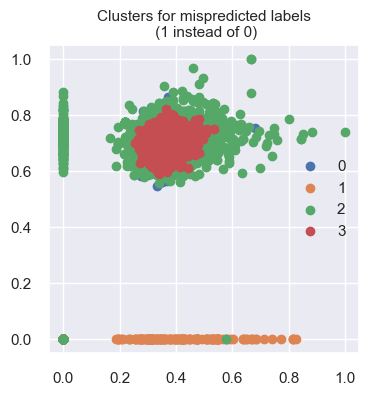

In [308]:
# Visualization
plt.rcParams["figure.figsize"] = (4,4)
sns.set(rc={'figure.figsize':(4,4)})
sns.set(font_scale=1.0)

# retrieve unique clusters
clusters = np.unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(yhat == cluster)
    # create scatter of these samples
    plt.scatter(X_train_scaled[row_ix, 0], X_train_scaled[row_ix, 1], label=cluster);

plt.title("Clusters for mispredicted labels\n (1 instead of 0)", y=1, fontsize=11)
# add legend to the plot
plt.legend()
# show the plot
plt.show();

In [309]:
df_failed_selected_0['cluster'] = yhat

### Describe clusters

In [310]:
for i in range(best_n):
    print("Cluster:",i)
    df_failed_selected_0[df_failed_selected_0['cluster'] == i].describe().loc[['min', 'max', 'mean', 'std']].T
    nan_count = (df_failed_selected_0 == -1).sum().sum()
    ic(nan_count);
    # df_failed_selected_0[df_failed_selected_0['cluster'] == i]['label'].value_counts()
    # df_failed_selected_0[df_failed_selected_0['cluster'] == i].sample(5).T

Cluster: 0


,min,max,mean,std
stats_char_count,109.00000,182.00000,141.194809,19.120930
w2v_gen_avg_word2vec_mean,-0.27739,0.14392,-0.075853,0.041190
aoa_aoa_kup_lem_mean,-1.00000,12.58000,6.086767,0.635940
w2v_ft_sen2vec_mean,-0.00543,0.00317,-0.000305,0.000829
label,0.00000,0.00000,0.000000,0.000000
y_pred,1.00000,1.00000,1.000000,0.000000
cluster,0.00000,0.00000,0.000000,0.000000


ic| nan_count: 1666


1666

Cluster: 1


,min,max,mean,std
stats_char_count,2.0,345.0,34.076482,43.549922
w2v_gen_avg_word2vec_mean,-1.0,-1.0,-1.000000,0.000000
aoa_aoa_kup_lem_mean,-1.0,15.5,1.794723,4.310734
w2v_ft_sen2vec_mean,-1.0,-1.0,-1.000000,0.000000
label,0.0,0.0,0.000000,0.000000
y_pred,1.0,1.0,1.000000,0.000000
cluster,1.0,1.0,1.000000,0.000000


ic| nan_count: 1666


1666

Cluster: 2


,min,max,mean,std
stats_char_count,1.00000,115.00000,83.624163,20.595591
w2v_gen_avg_word2vec_mean,-1.00000,0.32200,-0.066893,0.055734
aoa_aoa_kup_lem_mean,-1.00000,19.00000,6.153531,1.091484
w2v_ft_sen2vec_mean,-0.00725,0.00854,-0.000221,0.001033
label,0.00000,0.00000,0.000000,0.000000
y_pred,1.00000,1.00000,1.000000,0.000000
cluster,2.00000,2.00000,2.000000,0.000000


ic| nan_count: 1666


1666

Cluster: 3


,min,max,mean,std
stats_char_count,180.00000,520.00000,221.661277,37.405840
w2v_gen_avg_word2vec_mean,-0.22263,0.08371,-0.075378,0.037791
aoa_aoa_kup_lem_mean,4.06000,9.70000,6.180261,0.633012
w2v_ft_sen2vec_mean,-0.00396,0.00352,-0.000304,0.000765
label,0.00000,0.00000,0.000000,0.000000
y_pred,1.00000,1.00000,1.000000,0.000000
cluster,3.00000,3.00000,3.000000,0.000000


ic| nan_count: 1666


1666

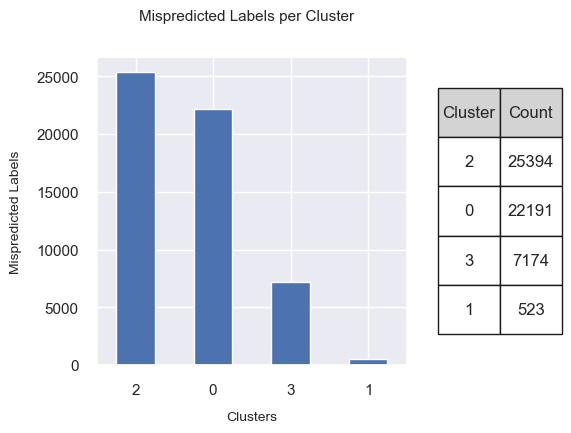

In [311]:
from matplotlib.table import Table

plt.rcParams["figure.figsize"] = (4,4)
fig, ax = plt.subplots()

# Create bar plot
df_failed_selected_0['cluster'].value_counts().plot(kind="bar", ax=ax)

ax.set_xlabel("Clusters", labelpad=10, fontsize=10)  # Increase x-axis label distance
ax.set_ylabel("Mispredicted Labels", labelpad=10, fontsize=10)   # Increase y-axis label distance
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)  # Rotate x-axis tick labels

# Create table
table_data = [['Cluster', 'Count']]
for cluster, count in df_failed_selected_0['cluster'].value_counts().items():
    table_data.append([cluster, count])

table = Table(ax, bbox=[1.1, 0.1, 0.4, 0.8])
table.auto_set_font_size(False)
table.set_fontsize(10)
for i, row in enumerate(table_data):
    for j, cell in enumerate(row):
        if i == 0:
            cell_color = 'lightgray' # set header row color
        else:
            cell_color = 'w'
        table.add_cell(i, j, width=0.3, height=0.1, text=cell, loc='center', facecolor=cell_color)

ax.add_table(table)

# Add super-title and adjust spacing
fig.suptitle("Mispredicted Labels per Cluster", y=1, fontsize=11)

plt.show();


**Conclusion**: Focusing on the clusters with the most mis-predicted lables: 2 and 0

### Show distribution of features

In [312]:
def plot_two_distributions(df, cluster1, cluster2, feature, n_bins=10):
    data1 = df[df['cluster'] == cluster1][feature]
    data2 = df[df['cluster'] == cluster2][feature]


    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True, sharex=True)

    # Plot histogram for cluster1
    n1, bins1, patches1 = ax1.hist(data1, bins=n_bins)
    mean_val1 = np.mean(data1)
    ax1.axvline(mean_val1, color='r', linestyle='--', linewidth=1, label='Mean')
    ax1.legend()
    ax1.set_xlabel(feature)
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'Histogram of Character Count in Cluster {cluster1}')

    # Plot histogram for cluster2
    n2, bins2, patches2 = ax2.hist(data2, bins=n_bins)
    mean_val2 = np.mean(data2)
    ax2.axvline(mean_val2, color='r', linestyle='--', linewidth=1, label='Mean')
    ax2.legend()
    ax2.set_xlabel(feature)
    #ax2.set_ylabel('Frequency')
    ax2.set_title(f'Histogram of Character Count in Cluster {cluster2}')

    plt.tight_layout()
    plt.show()


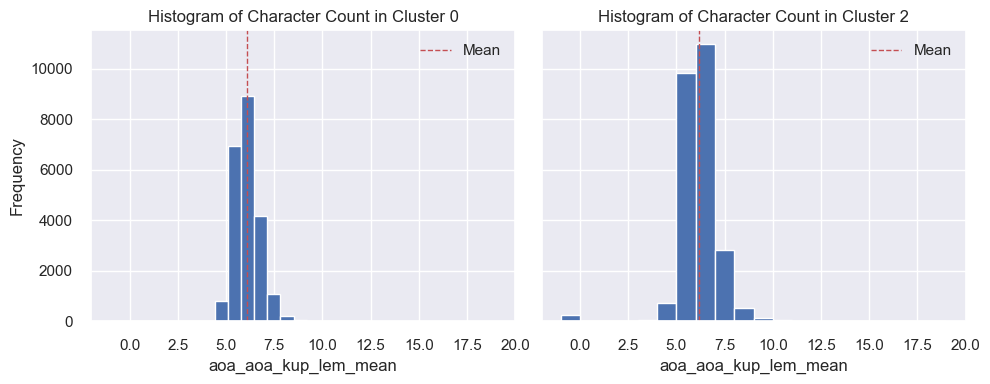

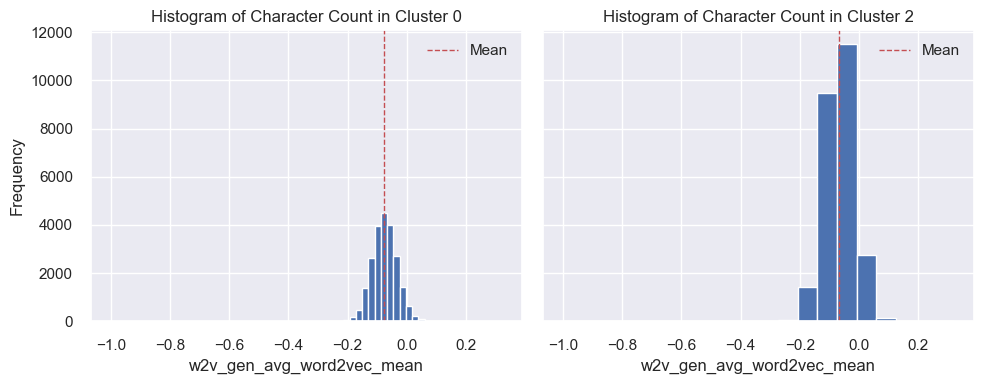

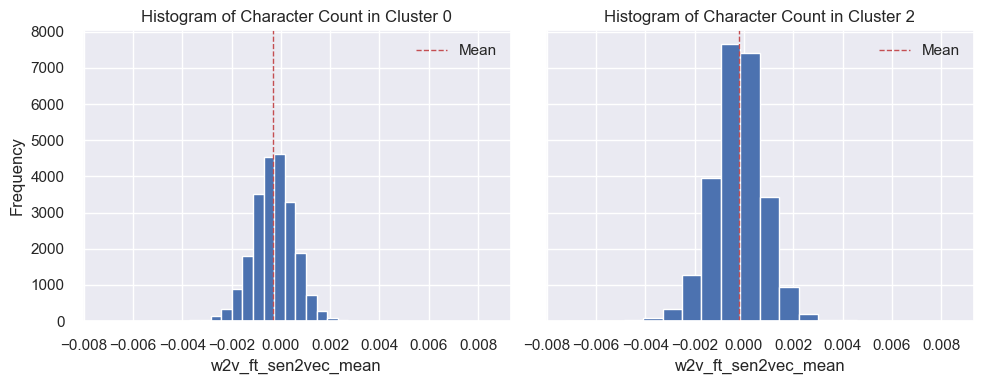

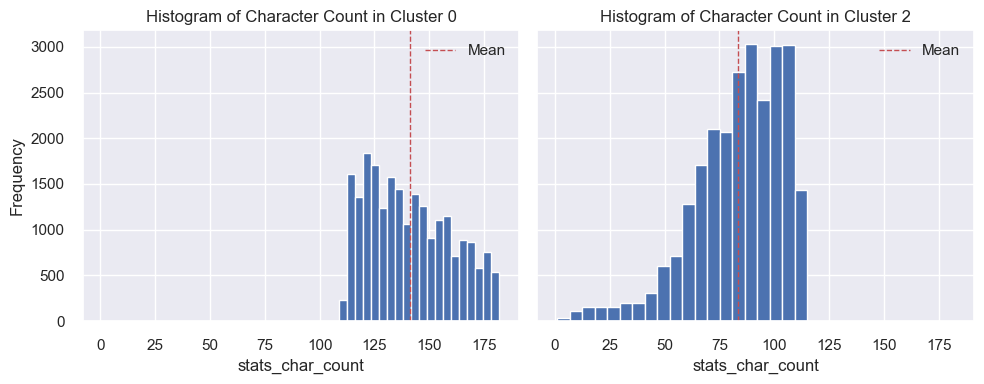

In [313]:
feature_list = list(set(important_feature_list) -{"label", "original_text", "cleaned_text", "stats_language_code", "y_pred"})

for feature in feature_list:
    plot_two_distributions(df_failed_selected_0, 0, 2, feature, 20)

In [314]:
aggregations = {
    'stats_char_count': ['count', 'min', 'max', 'mean', 'median', 'std'],
    'w2v_gen_avg_word2vec_mean': ['count', 'min', 'max', 'mean', 'median', 'std'],
    'aoa_aoa_kup_lem_mean': ['count', 'min', 'max', 'mean', 'median', 'std']
}
df_grouped = df_failed_selected_0.groupby('cluster').agg(aggregations)
df_grouped

stats_char_count                                          \
                   count  min  max        mean median        std   
cluster                                                            
0                  22191  109  182  141.194809  139.0  19.120930   
1                    523    2  345   34.076482   17.0  43.549922   
2                  25394    1  115   83.624163   87.0  20.595591   
3                   7174  180  520  221.661277  210.0  37.405840   

        w2v_gen_avg_word2vec_mean                                       \
                            count      min      max      mean   median   
cluster                                                                  
0                           22191 -0.27739  0.14392 -0.075853 -0.07636   
1                             523 -1.00000 -1.00000 -1.000000 -1.00000   
2                           25394 -1.00000  0.32200 -0.066893 -0.06656   
3                            7174 -0.22263  0.08371 -0.075378 -0.07536   

                  aoa_aoa_kup_lem_mean                                          
              std                count   min    max      mean median       std  
cluster                                                                         
0        0.041190                22191 -1.00  12.58  6.086767   6.02  0.635940  
1        0.000000                  523 -1.00  15.50  1.794723  -1.00  4.310734  
2        0.055734                25394 -1.00  19.00  6.153531   6.11  1.091484  
3        0.037791                 7174  4.06   9.70  6.180261   6.12  0.633012

### Cluster 0

In [315]:
df_failed_selected_0[(df_failed_selected_0['cluster'] == 0) & (df_failed_selected_0['aoa_aoa_kup_lem_mean'] > -1)]['aoa_aoa_kup_lem_mean'].min()


4.0

In [316]:
df_failed_selected_0[(df_failed_selected_0['cluster'] == 0) & (df_failed_selected_0['aoa_aoa_kup_lem_mean'] >= 5) & (df_failed_selected_0['aoa_aoa_kup_lem_mean'] <= 7.5) & (df_failed_selected_0['aoa_aoa_kup_lem_mean'] > 1)].sample(5).T


,390849,236573,407231,217147,222358
stats_char_count,163,143,145,114,120
w2v_gen_avg_word2vec_mean,-0.11252,-0.09259,-0.03051,-0.04039,-0.10951
aoa_aoa_kup_lem_mean,5.77,6.01,6.56,6.58,5.56
w2v_ft_sen2vec_mean,-0.00052,0.00005,0.00037,0.00045,0.00187
label,0,0,0,0,0
y_pred,1,1,1,1,1
original_text,"With Drake looking like they were going to continue to win , Burton started a plan to purposely lose the fourth Immunity challenge to get rid of the tribe 's weaker players such as Trish and Christa .",More praise was given to its size and future potential based on user-created content . Small criticism was made for certain parts of the gameplay and level creation tools .,"The palace is a complex of buildings , with the Papal Apartment , the Catholic Church 's government offices , a handful of chapels , the Vatican Museum and the Vatican library .",A thin film transistor liquid crystal display -LRB- TFT-LCD -RRB- is a technology which is used in LCD monitor and television displays .,"After the Yankees took a 4 - 2 lead on a Don Mattingly 2-RBI double in the 6th inning , the Mariners came back to tie the score at 4 - 4 in the 8th inning ."
cleaned_text,with drake looking like they were going to continue to win burton started a plan to purposely lose the fourth immunity challenge to get rid of the tribe weaker players such as trish and christa,more praise was given to its size and future potential based on user created content small criticism was made for certain parts of the gameplay and level creation tools,the palace is a complex of buildings with the papal apartment the catholic church government offices a handful of chapels the vatican museum and the vatican library,a thin film transistor liquid crystal display tft lcd is a technology which is used in lcd monitor and television displays,after the yankees took a 4 2 lead on a don mattingly 2 rbi double in the 6th inning the mariners came back to tie the score at 4 4 in the 8th inning
cluster,0,0,0,0,0


**Conclusion Cluster 0 (mis-predicted samples - 0 instead of 1)**
- For **cluster 0**: For all mis-predicted lables the **stats_char_count** is over 109 (min).
- In combination with **aoa_aoa_kup_lem_mean** over 4 (4.0), the true lable is most-likely incorrect and should be a 1 instead of a 0.
- This observation is also supported by the sampled sentences.

### Cluster 2

In [317]:
df_failed_selected_0[(df_failed_selected_0['cluster'] == 2) & (df_failed_selected_0['stats_char_count'] < 50)].sample(5).T


,296516,284396,406781,414268,253377
stats_char_count,23,7,2,38,49
w2v_gen_avg_word2vec_mean,-0.03813,-0.11045,-0.10799,-0.15612,-0.04433
aoa_aoa_kup_lem_mean,-1.0,3.75,-1.0,6.85,5.4
w2v_ft_sen2vec_mean,-0.00127,-0.0017,0.00081,-0.00245,0.00209
label,0,0,0,0,0
y_pred,1,1,1,1,1
original_text,Río Grande -LRB- M.D. -RRB-,In music,N !,"Szombathely , Hungary -LRB- since 1991 -RRB-","At the 2006 census , Airlie Beach had a population of 2,751 ."
cleaned_text,r o grande m d,in music,n,szombathely hungary since 1991,at the 2006 census airlie beach had a population of 2 751
cluster,2,2,2,2,2


**Conclusion Cluster 2 (mis-predicted samples - 0 instead of 1)**:
- For samples with a **stats_char_count** less than 50 we are most-likely looking at incomplete sentences.
- And if not, we would need to explore why the **aoa_aoa_kup_lem_mean** is high or why the value of -1 does not help with the prediction (maybe setting to 0).

## Clustering incorrect labels (true label 1)


Exlploring why the model predicted 0 instead of the true label 1.

In [318]:
# Prepare X and only use the relevant columns/features
X_columns_train = df_failed_selected_1.columns.to_list()
X_columns_train = list(set(X_columns_train) -{"label", "original_text", "cleaned_text", "stats_language_code", "y_pred"})

X = df_failed_selected_1[X_columns_train].copy()
y = df_failed_selected_1["label"]

ic(X.shape);
ic(y.shape);


ic| X.shape: (49437, 4)
ic| y.shape: (49437,)


In [319]:
# Normalize data using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X)


### Create Clusters

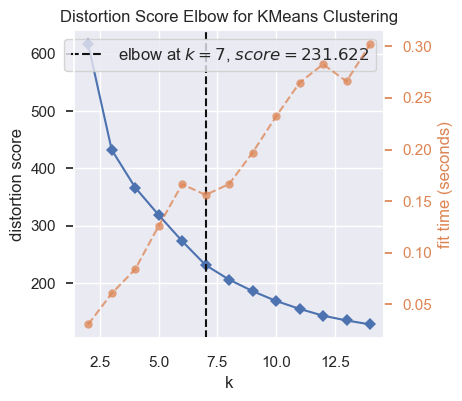

In [320]:
# Calculate best n_cluster value with Elbow method

# Visualization
plt.rcParams["figure.figsize"] = (4,4)
sns.set(rc={'figure.figsize':(4,4)})
sns.set(font_scale=1.0)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,15))

visualizer.fit(X_train_scaled)  # Fit the data to the visualizer

# Set title
visualizer.ax.set_title('Test')

# Finalize and render the figure
visualizer.show();


In [321]:
best_n = visualizer.elbow_value_
ic(best_n);

ic| best_n: 7


In [322]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=best_n, random_state=seed).fit(X_train_scaled)

# Get cluster labels
labels = kmeans.labels_

# Print cluster labels
print(labels)

yhat = kmeans.fit_predict(X_train_scaled);

[5 5 2 ... 5 5 0]


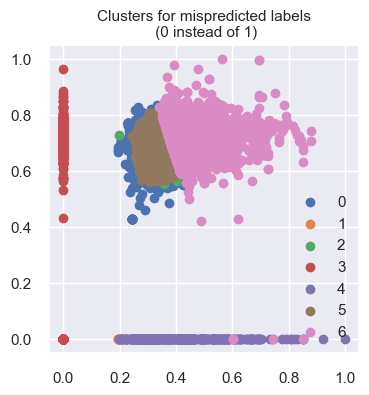

In [323]:
# Visualization
plt.rcParams["figure.figsize"] = (4,4)
sns.set(rc={'figure.figsize':(4,4)})
sns.set(font_scale=1.0)

# retrieve unique clusters
clusters = np.unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(yhat == cluster)
    # create scatter of these samples
    plt.scatter(X_train_scaled[row_ix, 0], X_train_scaled[row_ix, 1], label=cluster);

plt.title("Clusters for mispredicted labels\n (0 instead of 1)", y=1, fontsize=11)
# add legend to the plot
plt.legend()
# show the plot
plt.show();

In [324]:
df_failed_selected_1['cluster'] = yhat

### Describe clusters

In [325]:
for i in range(best_n):
    print("Cluster:",i)
    df_failed_selected_1[df_failed_selected_1['cluster'] == i].describe().loc[['min', 'max', 'mean', 'std']].T
    #nan_count = (df_failed_selected_1 == -1).sum().sum()
    #ic(nan_count);
    # df_failed_selected_0[df_failed_selected_0['cluster'] == i]['label'].value_counts()
    # df_failed_selected_0[df_failed_selected_0['cluster'] == i].sample(5).T

Cluster: 0


,min,max,mean,std
stats_char_count,4.00000,72.00000,49.515677,12.990961
w2v_gen_avg_word2vec_mean,-0.43223,0.10773,-0.087550,0.055203
aoa_aoa_kup_lem_mean,2.72000,7.12000,5.333706,0.561978
w2v_ft_sen2vec_mean,-0.00907,0.00556,-0.000461,0.001174
label,1.00000,1.00000,1.000000,0.000000
y_pred,0.00000,0.00000,0.000000,0.000000
cluster,0.00000,0.00000,0.000000,0.000000


Cluster: 1


,min,max,mean,std
stats_char_count,1.0,153.00,17.124046,18.427935
w2v_gen_avg_word2vec_mean,-1.0,-1.00,-1.000000,0.000000
aoa_aoa_kup_lem_mean,-1.0,3.06,-0.844389,0.762536
w2v_ft_sen2vec_mean,-1.0,-1.00,-1.000000,0.000000
label,1.0,1.00,1.000000,0.000000
y_pred,0.0,0.00,0.000000,0.000000
cluster,1.0,1.00,1.000000,0.000000


Cluster: 2


,min,max,mean,std
stats_char_count,115.00000,439.00000,142.453199,28.807491
w2v_gen_avg_word2vec_mean,-0.26768,0.07138,-0.086684,0.042820
aoa_aoa_kup_lem_mean,-1.00000,9.24000,5.514751,0.603397
w2v_ft_sen2vec_mean,-0.00536,0.00421,-0.000467,0.000865
label,1.00000,1.00000,1.000000,0.000000
y_pred,0.00000,0.00000,0.000000,0.000000
cluster,2.00000,2.00000,2.000000,0.000000


Cluster: 3


,min,max,mean,std
stats_char_count,1.00000,148.00000,20.052632,13.758873
w2v_gen_avg_word2vec_mean,-1.00000,0.28126,-0.131009,0.295171
aoa_aoa_kup_lem_mean,-1.00000,-1.00000,-1.000000,0.000000
w2v_ft_sen2vec_mean,-0.00785,0.00854,0.000100,0.002424
label,1.00000,1.00000,1.000000,0.000000
y_pred,0.00000,0.00000,0.000000,0.000000
cluster,3.00000,3.00000,3.000000,0.000000


Cluster: 4


,min,max,mean,std
stats_char_count,3.00,310.00,45.40380,42.188448
w2v_gen_avg_word2vec_mean,-1.00,-1.00,-1.00000,0.000000
aoa_aoa_kup_lem_mean,2.79,18.17,7.16038,2.665387
w2v_ft_sen2vec_mean,-1.00,-1.00,-1.00000,0.000000
label,1.00,1.00,1.00000,0.000000
y_pred,0.00,0.00,0.00000,0.000000
cluster,4.00,4.00,4.00000,0.000000


Cluster: 5


,min,max,mean,std
stats_char_count,67.00000,115.00000,87.297741,12.740925
w2v_gen_avg_word2vec_mean,-0.25739,0.08325,-0.085102,0.046310
aoa_aoa_kup_lem_mean,3.64000,8.21000,5.497575,0.532644
w2v_ft_sen2vec_mean,-0.00482,0.00411,-0.000437,0.000948
label,1.00000,1.00000,1.000000,0.000000
y_pred,0.00000,0.00000,0.000000,0.000000
cluster,5.00000,5.00000,5.000000,0.000000


Cluster: 6


,min,max,mean,std
stats_char_count,4.00000,137.00000,49.765082,17.091240
w2v_gen_avg_word2vec_mean,-1.00000,0.32745,-0.047180,0.059534
aoa_aoa_kup_lem_mean,5.52000,15.83000,7.216006,1.142928
w2v_ft_sen2vec_mean,-0.00725,0.00629,-0.000198,0.001365
label,1.00000,1.00000,1.000000,0.000000
y_pred,0.00000,0.00000,0.000000,0.000000
cluster,6.00000,6.00000,6.000000,0.000000


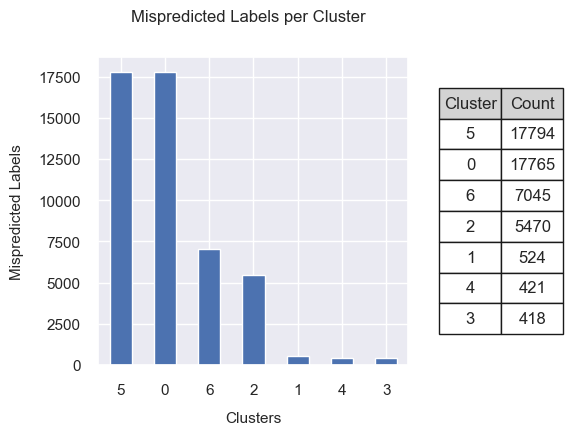

In [326]:
from matplotlib.table import Table

plt.rcParams["figure.figsize"] = (4,4)
fig, ax = plt.subplots()

# Create bar plot
df_failed_selected_1['cluster'].value_counts().plot(kind="bar", ax=ax)

ax.set_xlabel("Clusters", labelpad=10, fontsize=11)  # Increase x-axis label distance
ax.set_ylabel("Mispredicted Labels", labelpad=10, fontsize=11)   # Increase y-axis label distance
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)  # Rotate x-axis tick labels

# Create table
table_data = [['Cluster', 'Count']]
for cluster, count in df_failed_selected_1['cluster'].value_counts().items():
    table_data.append([cluster, count])

table = Table(ax, bbox=[1.1, 0.1, 0.4, 0.8])
table.auto_set_font_size(False)
table.set_fontsize(10)
for i, row in enumerate(table_data):
    for j, cell in enumerate(row):
        if i == 0:
            cell_color = 'lightgray' # set header row color
        else:
            cell_color = 'w'
        table.add_cell(i, j, width=0.3, height=0.1, text=cell, loc='center', facecolor=cell_color)

ax.add_table(table)

# Add super-title and adjust spacing
fig.suptitle("Mispredicted Labels per Cluster", y=1, fontsize=12)

plt.show();


### Show distribution of features

In [327]:
def plot_two_distributions(df, cluster1, cluster2, feature, n_bins=10):
    data1 = df[df['cluster'] == cluster1][feature]
    data2 = df[df['cluster'] == cluster2][feature]


    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True, sharex=True)

    # Plot histogram for cluster1
    n1, bins1, patches1 = ax1.hist(data1, bins=n_bins)
    mean_val1 = np.mean(data1)
    ax1.axvline(mean_val1, color='r', linestyle='--', linewidth=1, label='Mean')
    ax1.legend()
    ax1.set_xlabel(feature)
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'Histogram of Character Count in Cluster {cluster1}')

    # Plot histogram for cluster2
    n2, bins2, patches2 = ax2.hist(data2, bins=n_bins)
    mean_val2 = np.mean(data2)
    ax2.axvline(mean_val2, color='r', linestyle='--', linewidth=1, label='Mean')
    ax2.legend()
    ax2.set_xlabel(feature)
    #ax2.set_ylabel('Frequency')
    ax2.set_title(f'Histogram of Character Count in Cluster {cluster2}')

    plt.tight_layout()
    plt.show()


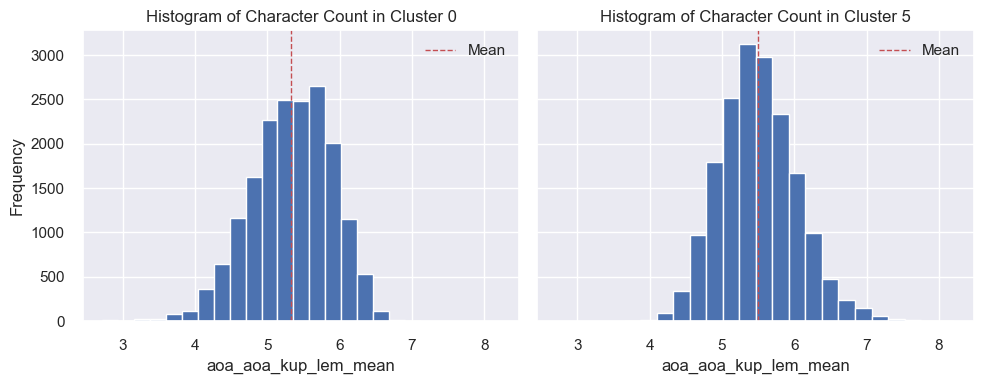

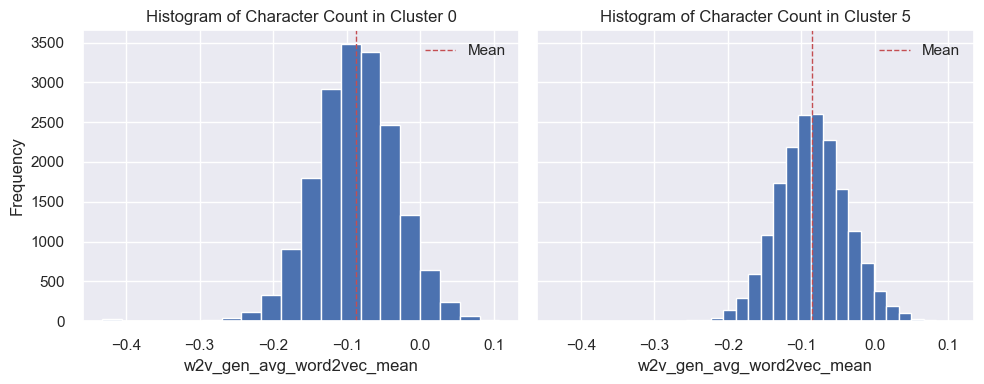

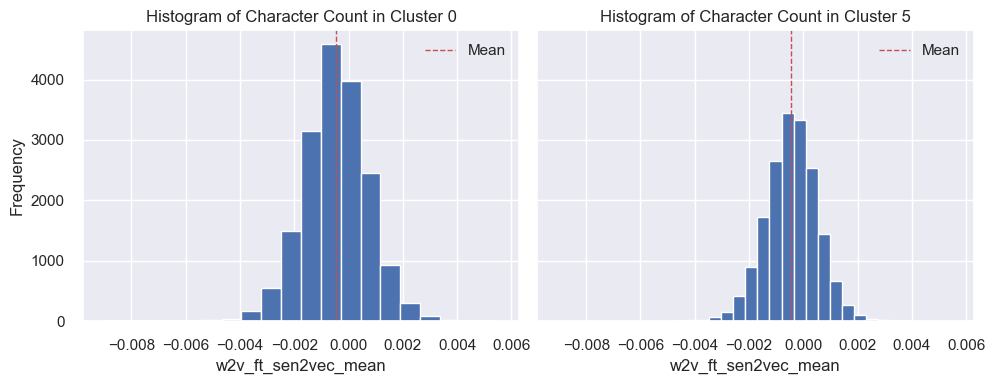

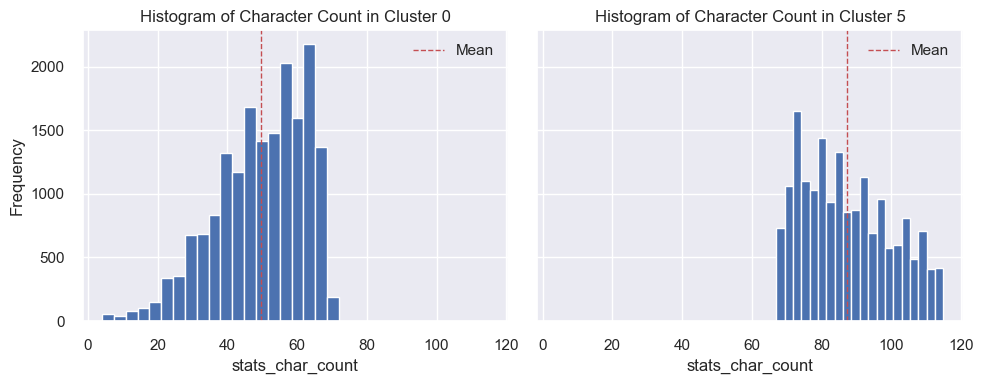

In [328]:
feature_list = list(set(important_feature_list) -{"label", "original_text", "cleaned_text", "stats_language_code", "y_pred"})

for feature in feature_list:
    plot_two_distributions(df_failed_selected_1, 0, 5, feature, 20)

In [329]:
aggregations = {
    'stats_char_count': ['count', 'min', 'max', 'mean', 'median', 'std'],
    'w2v_gen_avg_word2vec_mean': ['count', 'min', 'max', 'mean', 'median', 'std'],
    'aoa_aoa_kup_lem_mean': ['count', 'min', 'max', 'mean', 'median', 'std']
}
df_grouped = df_failed_selected_1.groupby('cluster').agg(aggregations)
df_grouped

stats_char_count                                          \
                   count  min  max        mean median        std   
cluster                                                            
0                  17765    4   72   49.515677   51.0  12.990961   
1                    524    1  153   17.124046   12.0  18.427935   
2                   5470  115  439  142.453199  134.0  28.807491   
3                    418    1  148   20.052632   17.0  13.758873   
4                    421    3  310   45.403800   33.0  42.188448   
5                  17794   67  115   87.297741   86.0  12.740925   
6                   7045    4  137   49.765082   50.0  17.091240   

        w2v_gen_avg_word2vec_mean                                        \
                            count      min      max      mean    median   
cluster                                                                   
0                           17765 -0.43223  0.10773 -0.087550 -0.086710   
1                             524 -1.00000 -1.00000 -1.000000 -1.000000   
2                            5470 -0.26768  0.07138 -0.086684 -0.088455   
3                             418 -1.00000  0.28126 -0.131009 -0.038100   
4                             421 -1.00000 -1.00000 -1.000000 -1.000000   
5                           17794 -0.25739  0.08325 -0.085102 -0.085645   
6                            7045 -1.00000  0.32745 -0.047180 -0.047480   

                  aoa_aoa_kup_lem_mean                                          
              std                count   min    max      mean median       std  
cluster                                                                         
0        0.055203                17765  2.72   7.12  5.333706   5.37  0.561978  
1        0.000000                  524 -1.00   3.06 -0.844389  -1.00  0.762536  
2        0.042820                 5470 -1.00   9.24  5.514751   5.41  0.603397  
3        0.295171                  418 -1.00  -1.00 -1.000000  -1.00  0.000000  
4        0.000000                  421  2.79  18.17  7.160380   6.90  2.665387  
5        0.046310                17794  3.64   8.21  5.497575   5.47  0.532644  
6        0.059534                 7045  5.52  15.83  7.216006   6.89  1.142928

### Cluster 0

In [336]:
df_failed_selected_1[(df_failed_selected_1['cluster'] == 0) & (df_failed_selected_1['stats_char_count'] >= 0) & (df_failed_selected_1['stats_char_count'] <= 72)].sample(5).T


,134516,188872,186269,124530,96336
stats_char_count,45,40,57,58,50
w2v_gen_avg_word2vec_mean,-0.11734,-0.08383,-0.13134,-0.11155,-0.09181
aoa_aoa_kup_lem_mean,4.58,5.41,6.1,5.41,5.13
w2v_ft_sen2vec_mean,-0.00185,0.00292,0.00006,-0.00035,-0.0008
label,1,1,1,1,1
y_pred,0,0,0,0,0
original_text,It was the worst accident in Romania in fifteen years .,The first Post Office opened on 1 November 1851 .,Jennifer Todd -LRB- born c. 1969 -RRB- is an American film producer .,'' 03 Bonnie & Clyde '' is a song by Jay-Z featuring R&B singer Beyoncé .,"Grover is shown to be a bit cowardly , getting afraid easily ."
cleaned_text,it was the worst accident in romania in fifteen years,the first post office opened on 1 november 1851,jennifer todd born c 1969 is an american film producer,03 bonnie clyde is a song by jay z featuring r b singer beyonce,grover is shown to be a bit cowardly getting afraid easily
cluster,0,0,0,0,0


### Cluster 5

In [337]:
df_failed_selected_1[(df_failed_selected_1['cluster'] == 5) & (df_failed_selected_1['stats_char_count'] >= 67)].sample(5).T


,102360,163600,131087,1164,199462
stats_char_count,69,71,71,100,85
w2v_gen_avg_word2vec_mean,-0.09809,-0.07186,-0.05501,-0.04899,-0.0675
aoa_aoa_kup_lem_mean,5.35,5.2,5.06,5.77,5.22
w2v_ft_sen2vec_mean,-0.00032,-0.0014,-0.00161,-0.00003,-0.00058
label,1,1,1,1,1
y_pred,0,0,0,0,0
original_text,"An avid reader , she also spent a lot of time exploring around her family 's 65 a farm .","Since 1935 , both sides of the Great Seal appear on the reverse of the one-dollar bill .","Saturn was the father of Ceres , Jupiter , Veritas , Pluto , and Neptune , among others .",The town grew after the nation 's administrative centre moved from Bremersdorp -LRB- now called Manzini -RRB- in 1902 .,"Originally built for up to one million inhabitants , the city has recently grown way past this number ."
cleaned_text,an avid reader she also spent a lot of time exploring around her family 65 a farm,since 1935 both sides of the great seal appear on the reverse of the one dollar bill,saturn was the father of ceres jupiter veritas pluto and neptune among others,the town grew after the nation administrative centre moved from bremersdorp now called manzini in 1902,originally built for up to one million inhabitants the city has recently grown way past this number
cluster,5,5,5,5,5


In [330]:
t_end = time.time()
calculate_duration(t_start, t_end);


0.19 minutes


# Watermark

In [333]:
%watermark

Last updated: 2023-02-27T11:04:25.938179+01:00

Python implementation: CPython
Python version       : 3.9.0
IPython version      : 8.9.0

Compiler    : Clang 11.0.0 
OS          : Darwin
Release     : 22.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit



In [334]:
%watermark --iversions

numpy     : 1.23.5
seaborn   : 0.12.2
matplotlib: 3.6.3
pandas    : 1.5.3

